In [28]:
import tensorflow as tf
import numpy as np
from numba import jit, cuda

import glob

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

tf.config.run_functions_eagerly(True)

In [2]:
# Import function file
execfile("pic2sketch_gan.py")

(256, 256, 3)


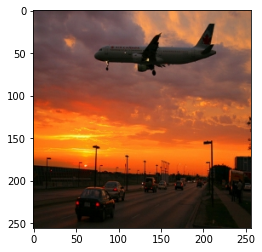

In [3]:
# Get data
PATH = 'data/sketch_and_images/'
sample_image = tf.io.read_file(str(PATH + 'train/n02691156_58.jpg'))
sample_image = tf.io.decode_png(sample_image)
print(sample_image.shape)

plt.figure()
plt.imshow(sample_image)

In [4]:
# Important path variables

# For photos:
PHOTO                 = 'photo/'
PHOTO_NON_UNI_SCALED  = 'tx_000000000000/'
PHOTO_BOUNDING_SCALED = 'tx_000100000000/'

# For sketches:
SKETCH                                  = 'sketch/'
SKT_SAME_SCALED                         = 'tx_000000000000/'
SKT_CNT_UNI_SCALED_GREATEST_DIM         = 'tx_000100000000/'
SKT_CNT_BOUNDING                        = 'tx_000000000010/'
SKT_CNT_BOUNDING_SCALED_LEAST_DIM       = 'tx_000000000110/'
SKT_CNT_BOUNDING_SCALED_GREATEST_DIM    = 'tx_000000001010/'
SKT_CNT_BOUNDING_NON_UNI_SCALED         = 'tx_000000001110/'

In [5]:
# Training set size
BUFFER_SIZE = 80

# Batch size
BATCH_SIZE = 10

# Image size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
# Figure out how to seperate data into train,test, validate
  
def load_image_train(photo_file):
    photo, sketch = load(photo_file)
    photo, sketch = rand_jitter(photo, sketch, IMG_HEIGHT, IMG_WIDTH)
    photo = normalize_photo(photo)
    sketch = normalize_sketch(sketch)
    
    return photo, sketch

def load_image_test(photo_file):
    photo, sketch = load(photo_file)
    photo, sketch = resize(photo, sketch, IMG_HEIGHT, IMG_WIDTH)
    photo = normalize_photo(photo)
    sketch = normalize_sketch(sketch)
    
    return photo, sketch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


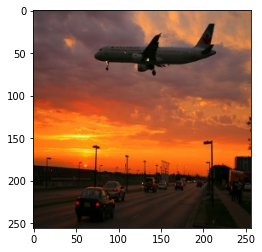

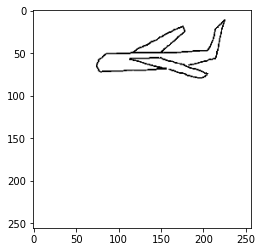

In [7]:
input, res = load(str(PATH + 'train/n02691156_58.jpg'))
plt.figure()
plt.imshow(input / 255.0)
plt.figure()
plt.imshow(res / 2.0)

In [8]:
# Format data correctly
def split(array):
    input = normalize_photo(array[0])
    real = normalize_sketch(array[1])
    return input, real

train_images = []
for img in glob.glob('data/sketch_and_images/train/*.jpg'):
    train_images.append(load(img))
    
test_images = []
for img in glob.glob('data/sketch_and_images/val/*.jpg'):
    test_images.append(load(img))

In [9]:
# Train dataset
train_data = tf.data.Dataset.from_tensor_slices(train_images)
train_data = train_data.map(split, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE)

# Test dataset
try:
    test_data = tf.data.Dataset.from_tensor_slices(test_images)
except tf.errors.InvalidArgumentError:
    test_data = tf.data.Dataset.from_tensor_slices(test_images)
test_data = test_data.map(split)
test_data = test_data.batch(BATCH_SIZE)

C:\Users\15136\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [10]:
# Generator helpers

OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

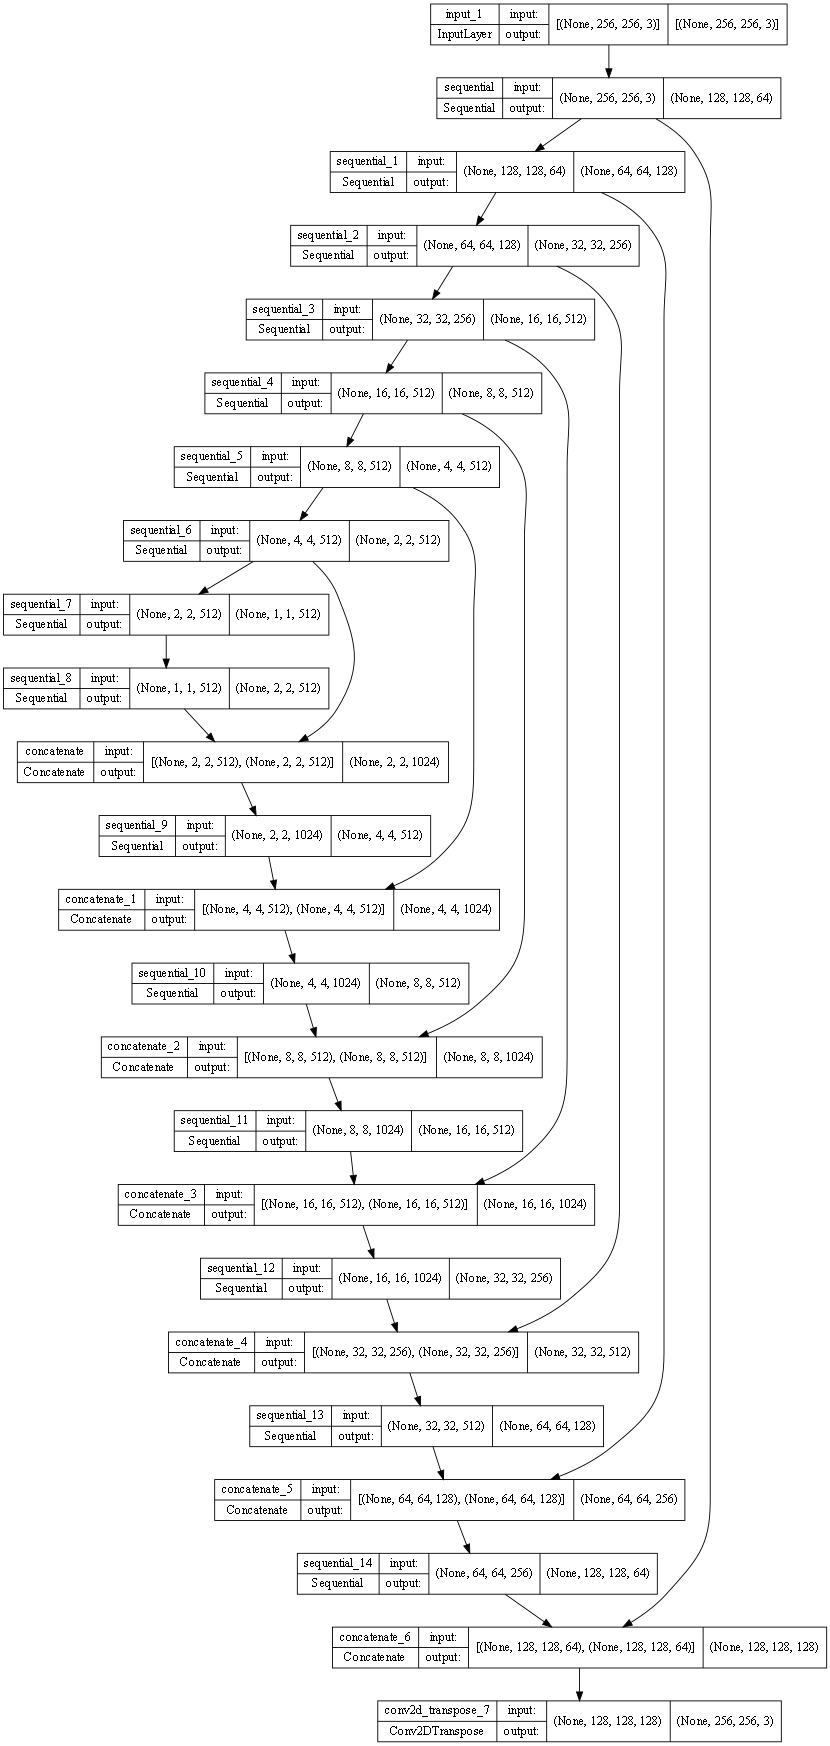

In [11]:
# Generator
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last_layer = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last_layer(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


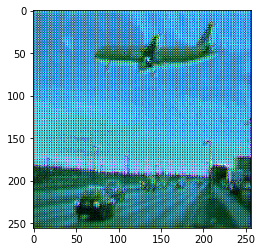

In [12]:
gen_output = generator(sample_image[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [13]:
# Generator Loss
LAMBDA = 100

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_obj(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # Mean abs error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

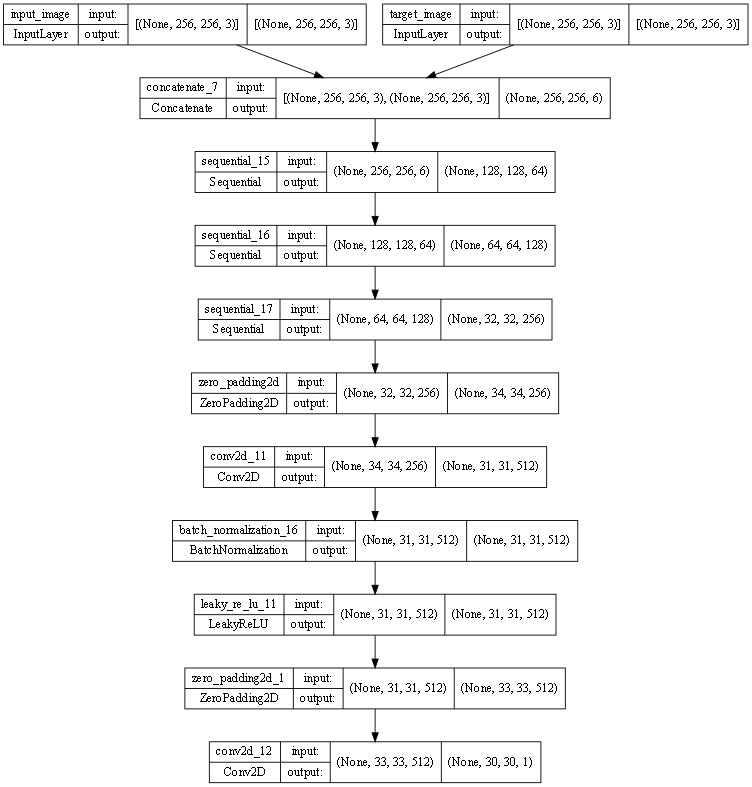

In [14]:
#Discriminator

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

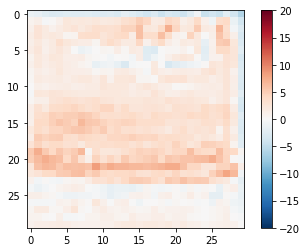

In [15]:
disc_out = discriminator([sample_image[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [16]:
# Discriminator Loss
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_obj(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_obj(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [17]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [18]:
# Checkpoint Saver
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


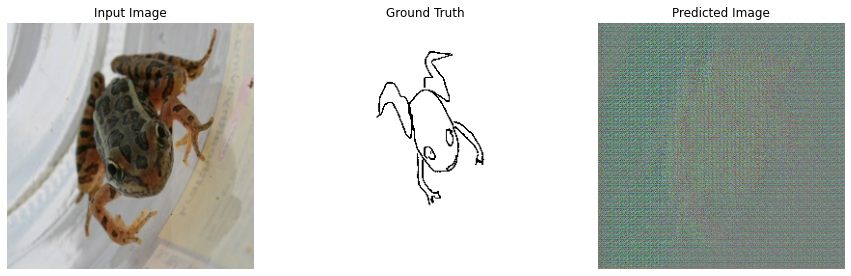

In [19]:
for example_input, example_target in test_data.take(1):
  gen_images(generator, example_input, example_target)

In [20]:
LOG_DIR = "logs/"

summary_writer = tf.summary.create_file_writer(LOG_DIR + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [21]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [29]:
@jit
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print("Time taken for 1000 steps: {} sec \n".format(time.time()-start))

      start = time.time()

      gen_images(generator, example_input, example_target)
      print("Step: {}k".format(step/1000))

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [23]:
%load_ext tensorboard
%tensorboard --logdir {LOG_DIR}

Reusing TensorBoard on port 6006 (pid 12604), started 6 days, 20:38:24 ago. (Use '!kill 12604' to kill it.)

In [30]:
fit(train_data, test_data, steps=2000)

KeyError: "Unrecognized options: {'target'}. Known options are dict_keys(['_nrt', 'boundscheck', 'debug', 'error_model', 'fastmath', 'forceinline', 'forceobj', 'inline', 'looplift', 'no_cfunc_wrapper', 'no_cpython_wrapper', 'no_rewrites', 'nogil', 'nopython', 'parallel', 'target_backend'])"

In [ ]:
#Display log
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

In [ ]:
# List checkpoints
ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)